<a href="https://colab.research.google.com/github/amithrajiv/Hackathon/blob/main/rlml_lab_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2303A51901

M.amith rajiv

Batch:- 09

Experimenting with different exploration strategies in a challenging environment


 Training strategy: random
[random] Episode 00 Reward = 16.0
[random] Episode 01 Reward = 15.0
[random] Episode 02 Reward = 12.0
[random] Episode 03 Reward = 14.0
[random] Episode 04 Reward = 38.0
[random] Episode 05 Reward = 14.0
[random] Episode 06 Reward = 15.0
[random] Episode 07 Reward = 23.0
[random] Episode 08 Reward = 23.0
[random] Episode 09 Reward = 11.0
[random] Episode 10 Reward = 28.0
[random] Episode 11 Reward = 18.0
[random] Episode 12 Reward = 10.0
[random] Episode 13 Reward = 20.0
[random] Episode 14 Reward = 17.0
[random] Episode 15 Reward = 11.0
[random] Episode 16 Reward = 32.0
[random] Episode 17 Reward = 17.0
[random] Episode 18 Reward = 25.0
[random] Episode 19 Reward = 17.0
[random] Episode 20 Reward = 18.0
[random] Episode 21 Reward = 21.0
[random] Episode 22 Reward = 19.0
[random] Episode 23 Reward = 50.0
[random] Episode 24 Reward = 14.0
[random] Episode 25 Reward = 51.0
[random] Episode 26 Reward = 19.0
[random] Episode 27 Reward = 23.0
[random] Episode 28 

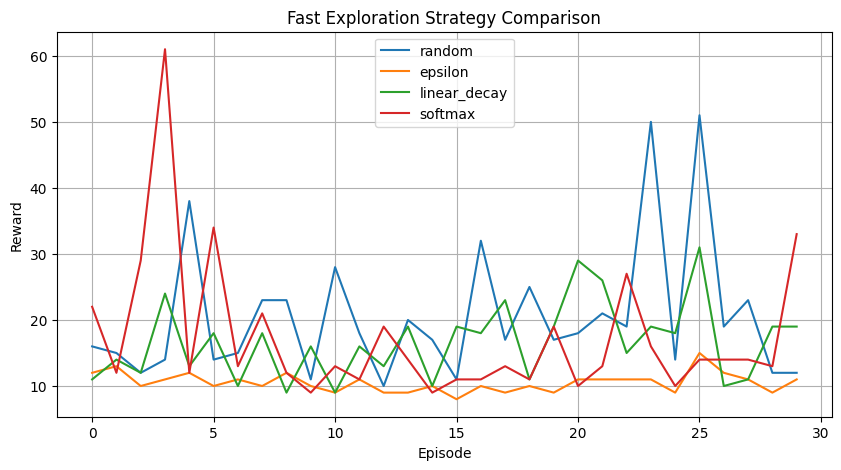

In [ ]:
import random
import math
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple("Transition", ("s", "a", "r", "s2", "d"))


# ---------------------- Replay Buffer ----------------------
class ReplayBuffer:
    def __init__(self, cap):
        self.buffer = deque(maxlen=cap)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch):
        t = random.sample(self.buffer, batch)
        return Transition(*zip(*t))

    def __len__(self):
        return len(self.buffer)


# ---------------------- Noisy Linear Layer ----------------------
class NoisyLinear(nn.Module):
    def __init__(self, in_f, out_f, sigma=0.017):
        super().__init__()
        self.in_f = in_f
        self.out_f = out_f

        self.weight_mu = nn.Parameter(torch.empty(out_f, in_f))
        self.weight_sigma = nn.Parameter(torch.empty(out_f, in_f))
        self.register_buffer("weight_eps", torch.empty(out_f, in_f))

        self.bias_mu = nn.Parameter(torch.empty(out_f))
        self.bias_sigma = nn.Parameter(torch.empty(out_f))
        self.register_buffer("bias_eps", torch.empty(out_f))

        self.reset_parameters()
        self.reset_noise()
        self.sigma = sigma

    def reset_parameters(self):
        bound = 1 / math.sqrt(self.in_f)
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.sigma)
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(self.sigma)

    def reset_noise(self):
        eps_in = torch.randn(self.in_f, device=DEVICE)
        eps_out = torch.randn(self.out_f, device=DEVICE)

        eps_in = eps_in.sign() * eps_in.abs().sqrt()
        eps_out = eps_out.sign() * eps_out.abs().sqrt()

        self.weight_eps.copy_(eps_out.outer(eps_in))
        self.bias_eps.copy_(eps_out)

    def forward(self, x):
        if self.training:
            w = self.weight_mu + self.weight_sigma * self.weight_eps
            b = self.bias_mu + self.bias_sigma * self.bias_eps
        else:
            w = self.weight_mu
            b = self.bias_mu
        return F.linear(x, w, b)


# ---------------------- DQN Model ----------------------
class DQN(nn.Module):
    def __init__(self, s_dim, a_dim, noisy=False):
        super().__init__()
        if noisy:
            self.fc1 = NoisyLinear(s_dim, 32)
            self.fc2 = NoisyLinear(32, 32)
            self.fc3 = NoisyLinear(32, a_dim)
            self.noisy = True
        else:
            self.fc1 = nn.Linear(s_dim, 32)
            self.fc2 = nn.Linear(32, 32)
            self.fc3 = nn.Linear(32, a_dim)
            self.noisy = False

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def reset_noise(self):
        if self.noisy:
            for m in self.modules():
                if isinstance(m, NoisyLinear):
                    m.reset_noise()


# ---------------------- Agent ----------------------
class Agent:
    def __init__(self, s_dim, a_dim, strategy="linear_decay"):
        self.strategy = strategy
        self.a_dim = a_dim

        self.policy = DQN(s_dim, a_dim, noisy=(strategy == "noisy")).to(DEVICE)
        self.target = DQN(s_dim, a_dim, noisy=(strategy == "noisy")).to(DEVICE)
        self.target.load_state_dict(self.policy.state_dict())

        self.opt = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.gamma = 0.99
        self.buffer = ReplayBuffer(5000)
        self.batch = 32
        self.steps = 0

        # Exploration params
        self.eps_start = 1.0
        self.eps_end = 0.1
        self.eps_decay = 5000
        self.fixed_eps = 0.2
        self.temperature = 1.0

    def select(self, state):
        state_v = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        q = self.policy(state_v).detach().cpu().numpy().squeeze()

        # Random
        if self.strategy == "random":
            return random.randrange(self.a_dim)

        # Fixed epsilon
        if self.strategy == "epsilon":
            return random.randrange(self.a_dim) if random.random() < self.fixed_eps else int(np.argmax(q))

        # Linear epsilon decay
        if self.strategy == "linear_decay":
            eps = self.eps_end + (self.eps_start - self.eps_end) * max(0, (1 - self.steps / self.eps_decay))
            self.steps += 1
            return random.randrange(self.a_dim) if random.random() < eps else int(np.argmax(q))

        # Softmax
        if self.strategy == "softmax":
            temp = max(0.1, self.temperature * (1 - self.steps / (self.eps_decay * 2)))
            self.steps += 1
            probs = np.exp(q / temp)
            probs /= probs.sum()
            return int(np.random.choice(self.a_dim, p=probs))

        # NoisyNet
        if self.strategy == "noisy":
            self.policy.reset_noise()
            q = self.policy(state_v).detach().cpu().numpy().squeeze()
            return int(np.argmax(q))

        return int(np.argmax(q))

    def train_step(self):
        if len(self.buffer) < self.batch:
            return None

        B = self.buffer.sample(self.batch)
        s = torch.tensor(B.s, dtype=torch.float32, device=DEVICE)
        a = torch.tensor(B.a, dtype=torch.int64, device=DEVICE).unsqueeze(1)
        r = torch.tensor(B.r, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        s2 = torch.tensor(B.s2, dtype=torch.float32, device=DEVICE)
        d = torch.tensor(B.d, dtype=torch.float32, device=DEVICE).unsqueeze(1)

        q = self.policy(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target(s2).max(1)[0].unsqueeze(1)
            target = r + (1 - d) * self.gamma * q_next

        loss = F.mse_loss(q, target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        return loss.item()


# ---------------------- Training Loop ----------------------
def train(strategy="linear_decay", episodes=30):
    env = gym.make("CartPole-v1")
    agent = Agent(env.observation_space.shape[0], env.action_space.n, strategy=strategy)

    rewards = []
    for ep in range(episodes):
        s, _ = env.reset()
        total_r = 0

        for _ in range(200):  # reduced max steps
            a = agent.select(s)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            agent.buffer.push(s, a, r, s2, float(done))
            agent.train_step()

            s = s2
            total_r += r
            if done:
                break

        rewards.append(total_r)
        agent.target.load_state_dict(agent.policy.state_dict())

        print(f"[{strategy}] Episode {ep:02d} Reward = {total_r}")

    env.close()
    return rewards


# ---------------------- Compare Strategies ----------------------
if __name__ == "__main__":
    strategies = ["random", "epsilon", "linear_decay", "softmax"]
    results = {}

    for s in strategies:
        print("\n=================================")
        print(" Training strategy:", s)
        print("=================================")
        results[s] = train(strategy=s, episodes=30)

    # Plot
    plt.figure(figsize=(10, 5))
    for s, r in results.items():
        plt.plot(r, label=s)

    plt.legend()
    plt.title("Fast Exploration Strategy Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid()
    plt.show()
